![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# DMD of the flow past a circular cylinder

In each tutorial collection of dimensionality reduction techniques, there must be at least one analysis of the flow past a circular cylinder. In this notebook, we perform a similar analysis as in section 2.3.3 of [Dynamic Mode Decomposition: Data-Driven Modeling of Complex Systems](https://epubs.siam.org/doi/book/10.1137/1.9781611974508). The example is closely related to the notebook [SVD of the flow past a circular cylinder](svd_cylinder.ipynb). Refer to the latter notebook for more information about the geometry, the simulation setup, and the SVD. For a friendly introduction to DMD, refer to the notebook [An introduction to dynamic mode decomposition](dmd_intro.ipynb).

In [1]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Data matrix

First, we load all **vortictiy** snapshots with $t\ge 4s$ and assemble them to a data matrix. In contrast to the SVD, we do not subtract the mean in this tutorial. We could subtract a baseflow, e.g., the temporal mean, but the outcome would be qualitatively the same in this example. We also use the same mask as in the SVD-based tutorial.

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(path)
times = loader.write_times
window_times = [time for time in times if float(time) >= 4.0]

# load vertices, discard z-coordinate, and create a mask
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

# assemble data matrix
data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
for i, time in enumerate(window_times):
    # load the vorticity vector field, take the z-component [:, 2], and apply the mask
    data_matrix[:, i] = pt.masked_select(loader.load_snapshot("vorticity", time)[:, 2], mask)

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


## Dynamic mode decomposition

One important step within the DMD is the truncated SVD. By looking at the singual values in the [SVD notebook](svd_cylinder.ipynb), we determined that a rank trunction with $r=19$ is sufficient to preserve about $99\%$ of the variance in the data. The DMD class computes the SVD and several other quantities for us:
- eigenvalues of the approximated linear operator
- DMD modes (spatial structures coherent in time)
- frequency, growth rate, and amplitude associated with each mode
- the time dynamics associated with each mode
- the DMD reconstruction of the original data

In [3]:
dt = float(times[1]) - float(times[0])
dmd = DMD(data_matrix, dt=dt, rank=19)
print(dmd)

SVD:
SVD of a 7190x240 data matrix
Selected/optimal rank: 19/97
data type: torch.float32 (4b)
truncated SVD size: 551.5195Kb
LSQ:
Overall DMD size: 1.5837Mb


We begin the analysis by examining the eigen values. Because we used a real data matrix in this example, the eigenvalues appear complex conjugate pairs. All eigenvalues are placed allmost exactly on the unit circle, which indicates that the associated modes are stable. The zeroth eigenvalue has no imaginary part and represents the steady *background mode*. The number of eigenvalues corresponds to the rank selected for the SVD trunction (19 in this example).

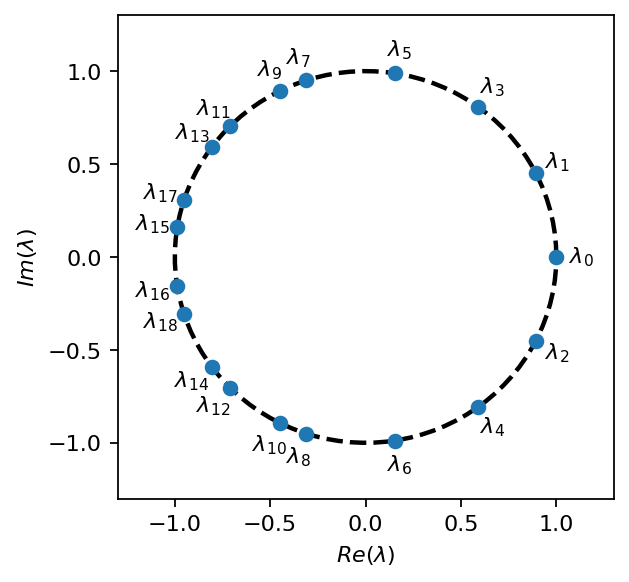

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, zorder=7)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
for i, val in enumerate(dmd.eigvals):
    index = "{" + f"{i}" + "}"
    ax.annotate(r"$\lambda_{:s}$".format(index), (val.real*1.13, val.imag*1.13), ha='center', va="center")
plt.show()

The DMD is a spectral analysis method, meaning that it provides us with frequency and amplitude associated with each mode. In the plot below, the modes with the 10 largest amplitudes (not considering the steady mode) have their frequencies annotated. All frequencies are approximately multiples of the natural vortex shedding frequency, which is about $6Hz$ in the present case ($3Hz$ considering the drag force acting on the cylinder).

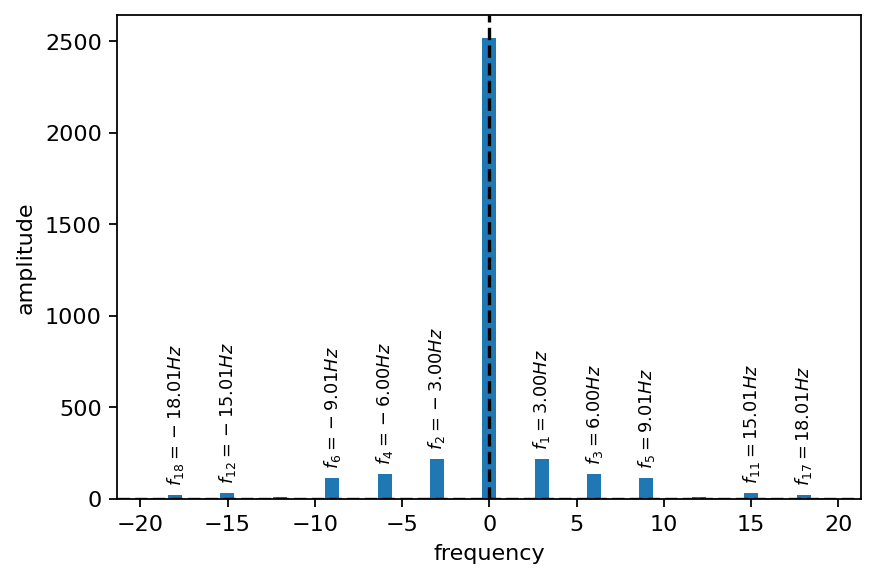

In [5]:
fig, ax = plt.subplots()
amplitude = dmd.amplitude.real.abs()
_, ind = pt.topk(amplitude, 11)
ax.bar(dmd.frequency, amplitude)
for i, (a, f) in enumerate(zip(amplitude, dmd.frequency)):
    if i in ind[1:]:
        text = r"$f_{:s} = {:2.2f} Hz$".format("{"+f"{i}"+"}", f)
        ax.annotate(text, (f, a+80), ha="center", fontsize=8, rotation=90)
ax.axhline(0.0, ls="--", c="k")
ax.axvline(0.0, ls="--", c="k")
ax.set_xlabel("frequency")
ax.set_ylabel("amplitude")
plt.show()

The DMD decomposes out data in spatial structures that are coherent in time and the corresponding temporal behavior of each mode. In the plot below, we visualize the time dynamics of some of the more important modes (considering their amplitude). It is noticeable that the singals become edgier for modes associated with higher frequencies. Sampling the snapshots at a higher rate would improve this behavior.

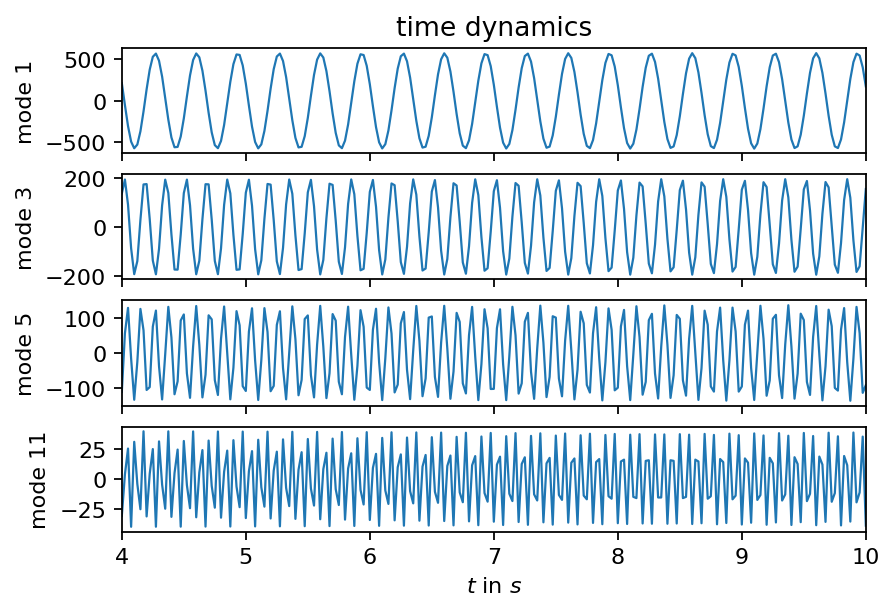

In [6]:
fig, axarr = plt.subplots(4, 1, sharex=True)

times_num = [float(t) for t in window_times]
modes = [1, 3, 5, 11]
for i, m in enumerate(modes):
    axarr[i].plot(times_num, dmd.dynamics[m].real, lw=1)
    axarr[i].set_ylabel(f"mode {m}")
axarr[-1].set_xlabel(r"$t$ in $s$")
axarr[-1].set_xlim(4.0, 10.0)
axarr[0].set_title("time dynamics")
plt.show()

Next, we visualize the DMD modes starting with the steady background mode. Note that the background mode is not perfectly symmetric with respect to the line $(x, y=0.2)$ because the setup itself is not symmetric. Refer to SVD example for more information.

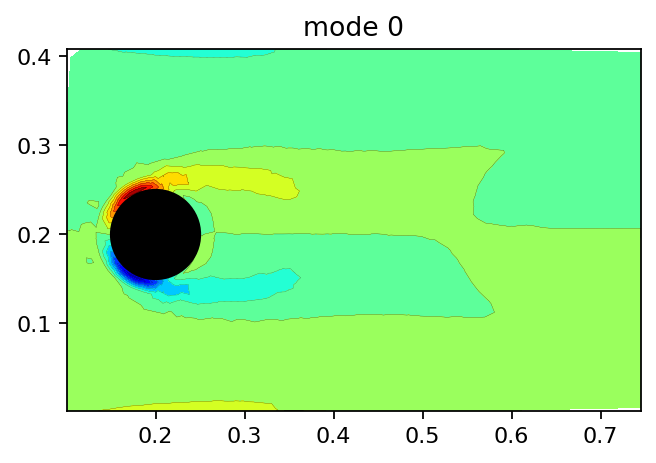

In [7]:
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

def add_mode(ax, mode, title, every=4):
    ax.tricontourf(x[::every], y[::every], mode[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], mode[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)

fig, ax = plt.subplots(figsize=(5, 3))
add_mode(ax, dmd.modes[:, 0].real, "mode 0")
plt.show()

Below, we show the real and imaginary parts of several DMD modes. We omit the even modes since they are identical to the odd modes but have an imaginary part with reversed sign. Besides the steady mode, modes 1, 3, and 5 are associated with the highest amplitudes.

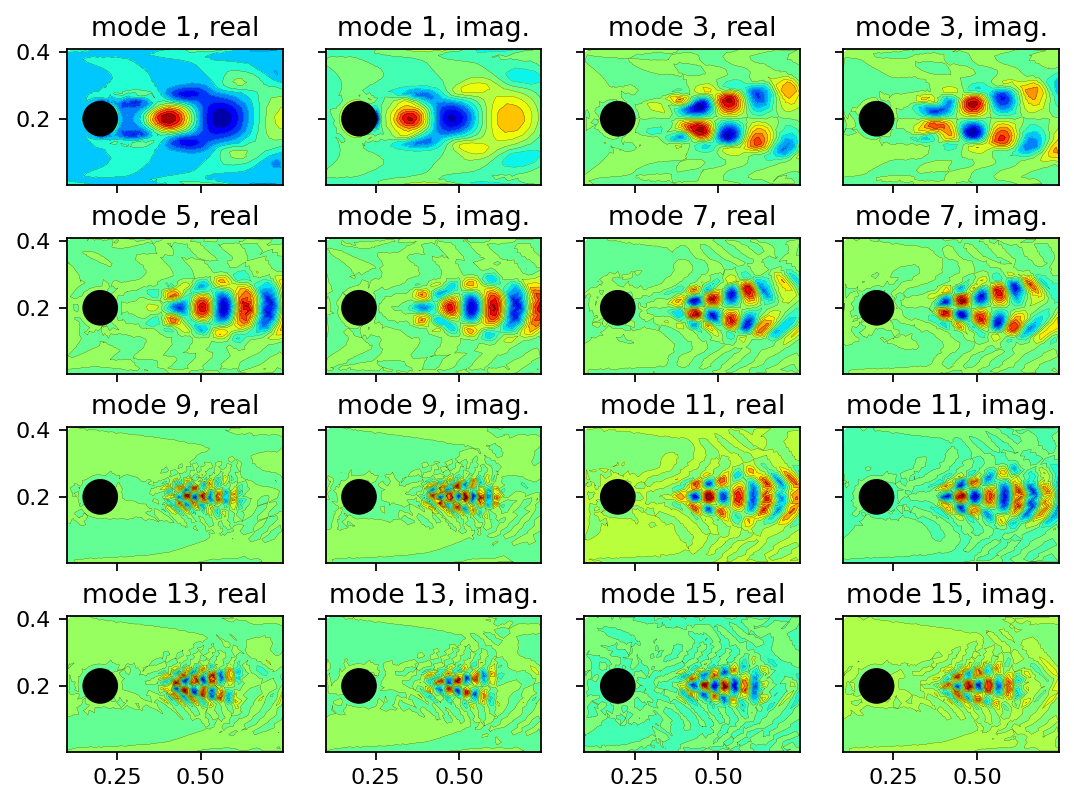

In [8]:
fig, axarr = plt.subplots(4, 4, figsize=(8, 6), sharex=True, sharey=True)
count = 1
for row in range(4):
    add_mode(axarr[row, 0], dmd.modes[:, count].real, f"mode {count}, real")
    add_mode(axarr[row, 1], dmd.modes[:, count].imag, f"mode {count}, imag.")
    count += 2
    add_mode(axarr[row, 2], dmd.modes[:, count].real, f"mode {count}, real")
    add_mode(axarr[row, 3], dmd.modes[:, count].imag, f"mode {count}, imag.")
    count += 2
plt.show()

Finially, we can evaluate how well the DMD represents the original data by reconstructing the snapshots. If the DMD amplitudes are computed based on a snapshot at a selected time instance, the reconstruction error typically varies over time. By default, the amplitudes in flowTorch are computed based on the first snapshot in the data matrix. Optimized variants of the DMD, like sparsity-promoting DMD, create a more homogeneously distributed reconstruction error.

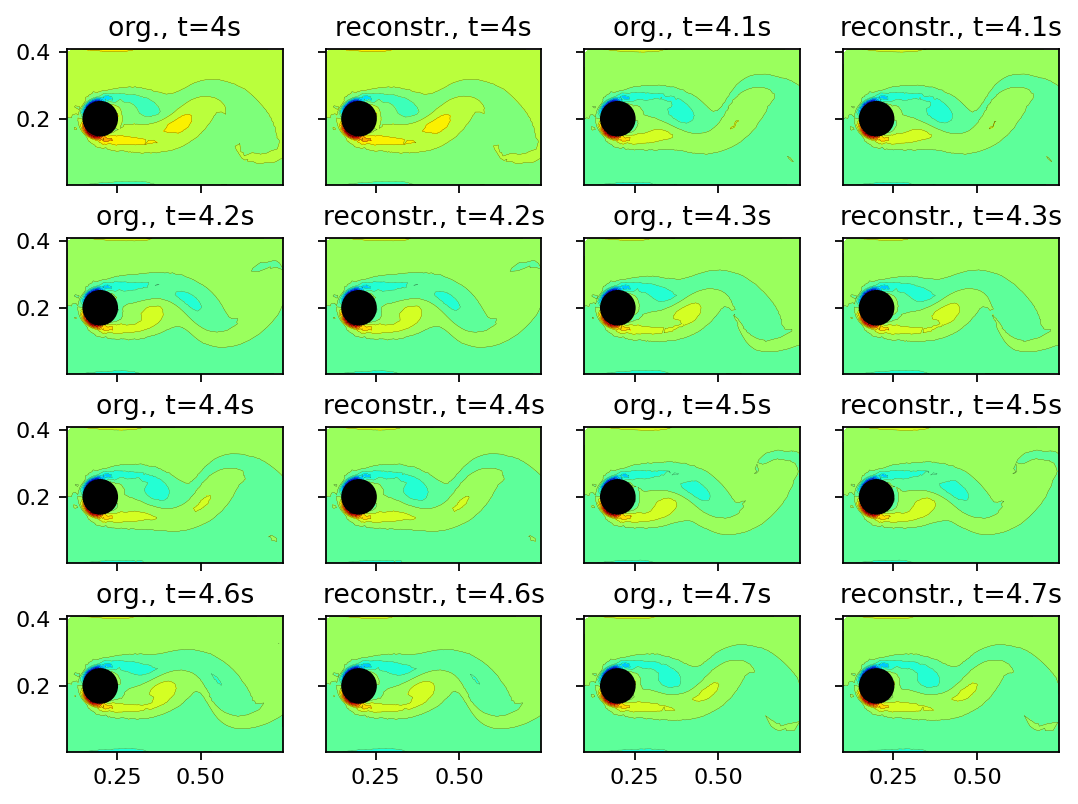

In [9]:
reconstruction = dmd.reconstruction

fig, axarr = plt.subplots(4, 4, figsize=(8, 6), sharex=True, sharey=True)
count = 0
for row in range(4):
    add_mode(axarr[row, 0], data_matrix[:, count], f"org., t={window_times[count]}s")
    add_mode(axarr[row, 1], reconstruction[:, count], f"reconstr., t={window_times[count]}s")
    count += 4
    add_mode(axarr[row, 2], data_matrix[:, count], f"org., t={window_times[count]}s")
    add_mode(axarr[row, 3], reconstruction[:, count], f"reconstr., t={window_times[count]}s")
    count += 4
plt.show()

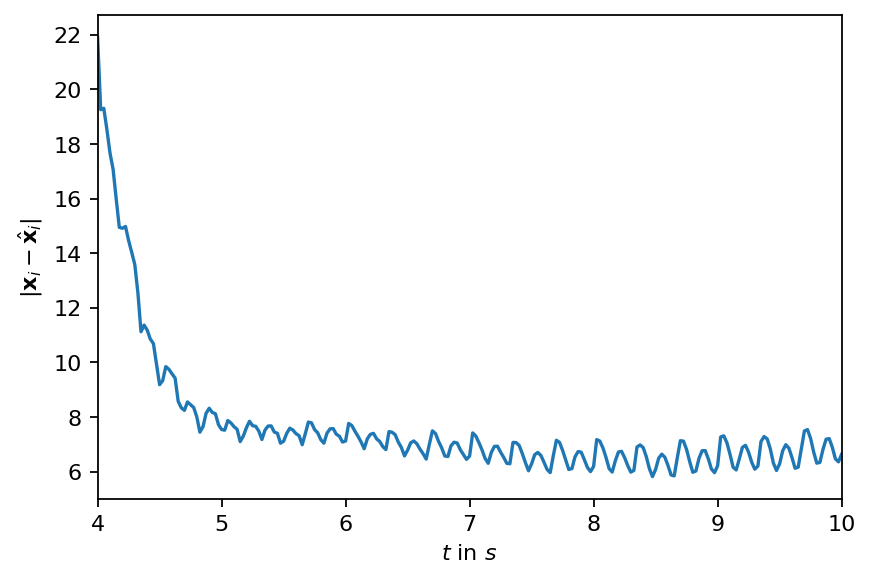

In [10]:
error = pt.linalg.norm(data_matrix - reconstruction, dim=0)

fig, ax = plt.subplots()
ax.plot(times_num, error)
ax.set_xlabel(r"$t$ in $s$")
ax.set_ylabel(r"$|\mathbf{x}_i - \hat{\mathbf{x}}_i|$")
ax.set_xlim(4.0, 10.0)
plt.show()